In [22]:
import flask
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import psycopg2 as pg
import pandas.io.sql as psql
plt.style.use('ggplot')

%matplotlib inline

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, GaussianNB
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import roc_curve,roc_auc_score


pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',25)
pd.set_option('display.precision',3)

# Pulling Data from SQL

In [27]:
connection = pg.connect("dbname=srazvi3 user=syedrazvi")
 
Full_DF = psql.read_sql("SELECT * FROM twitter_bots", connection)

In [ ]:
Full_DF

# Cleaning and Formatting the Data

In [3]:
df = Full_DF.drop(['Unnamed: 0','created_at','id','screen_name'], axis =1)
df['default_profile'] = df['default_profile'].astype(int)
df['default_profile_image'] = df['default_profile_image'].astype(int)
df['geo_enabled'] = df['geo_enabled'].astype(int)
df['verified'] = df['verified'].astype(int)
df['description'] = df['description'].notnull().astype(int)
df['profile_background_image_url'] = df['profile_background_image_url'].notnull().astype(int)
df['profile_image_url'] = df['profile_image_url'].notnull().astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37438 entries, 0 to 37437
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   default_profile               37438 non-null  int64  
 1   default_profile_image         37438 non-null  int64  
 2   description                   37438 non-null  int64  
 3   favourites_count              37438 non-null  int64  
 4   followers_count               37438 non-null  int64  
 5   friends_count                 37438 non-null  int64  
 6   geo_enabled                   37438 non-null  int64  
 7   lang                          29481 non-null  object 
 8   location                      37435 non-null  object 
 9   profile_background_image_url  37438 non-null  int64  
 10  profile_image_url             37438 non-null  int64  
 11  statuses_count                37438 non-null  int64  
 12  verified                      37438 non-null  int64  
 13  a

In [4]:
# Dummying the language and location fields
df['eng'] = df['lang'].apply(lambda x: 1 if x == 'en' else 0) 
df['locd'] = df['location'].apply(lambda x: 0 if x == 'unknown' else 1) 

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37438 entries, 0 to 37437
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   default_profile               37438 non-null  int64  
 1   default_profile_image         37438 non-null  int64  
 2   description                   37438 non-null  int64  
 3   favourites_count              37438 non-null  int64  
 4   followers_count               37438 non-null  int64  
 5   friends_count                 37438 non-null  int64  
 6   geo_enabled                   37438 non-null  int64  
 7   lang                          29481 non-null  object 
 8   location                      37435 non-null  object 
 9   profile_background_image_url  37438 non-null  int64  
 10  profile_image_url             37438 non-null  int64  
 11  statuses_count                37438 non-null  int64  
 12  verified                      37438 non-null  int64  
 13  a

In [83]:
df['account_type'].value_counts()

human    25013
bot      12425
Name: account_type, dtype: int64

In [6]:
# Undersampling the human accounts to be roughly even with the bot accounts
df = df.drop(df['account_type'][df['account_type'] == 'human'].sample(frac=.5).index)

In [100]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24932 entries, 0 to 37437
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   default_profile               24932 non-null  int64  
 1   default_profile_image         24932 non-null  int64  
 2   description                   24932 non-null  int64  
 3   favourites_count              24932 non-null  int64  
 4   followers_count               24932 non-null  int64  
 5   friends_count                 24932 non-null  int64  
 6   geo_enabled                   24932 non-null  int64  
 7   lang                          18706 non-null  object 
 8   location                      24929 non-null  object 
 9   profile_background_image_url  24932 non-null  int64  
 10  profile_image_url             24932 non-null  int64  
 11  statuses_count                24932 non-null  int64  
 12  verified                      24932 non-null  int64  
 13  a

# K-Nearest Neighbors

In [7]:
#Typical Train Test Holdout Split
X = df.drop(['account_type','location','lang'],axis=1)
y = df.account_type

le = LabelEncoder()
le.fit(y)
y = le.fit_transform(y)

X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=0.20)

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.25)

In [102]:
#Confirming that 0 is bot and 1 is human
print(y)
df.account_type

[0 1 1 ... 1 1 0]


0          bot
1        human
2        human
3        human
4        human
         ...  
37432      bot
37434    human
37435    human
37436    human
37437      bot
Name: account_type, Length: 24932, dtype: object

In [8]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
k_scores = []

for n in range(1,51):
    knn = KNeighborsClassifier(n_neighbors=n, n_jobs=-1)
    knn.fit(X_train, y_train)
    knn_preds = knn.predict(X_test)
    scores = cross_val_score(knn, X_test, y_test, cv=3, scoring='accuracy')
    k_scores.append(scores.mean())

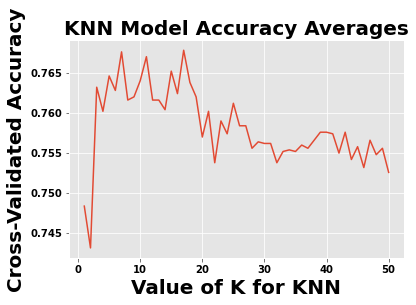

In [9]:
plt.plot(range(1,51), k_scores)
plt.xlabel('Value of K for KNN',fontsize = 20, weight = 'bold',color='black')
plt.ylabel('Cross-Validated Accuracy',fontsize = 20, weight = 'bold',color='black')
plt.title('KNN Model Accuracy Averages',fontsize = 20, weight = 'bold',color='black')
plt.xticks(fontsize = 10, weight = 'bold',color='black')
plt.yticks(fontsize = 10, weight = 'bold',color='black')
plt.savefig('neighbors.png',dpi=300)

In [10]:
X_holdout = scaler.transform(X_holdout)

knn = KNeighborsClassifier(n_neighbors=10, n_jobs=-1)
knn.fit(X_train, y_train)
knn_preds = knn.predict(X_holdout)
knn_proba = knn.predict_proba(X_holdout)

print(confusion_matrix(y_holdout, knn_preds))
print(classification_report(y_holdout, knn_preds))

[[2118  354]
 [ 721 1794]]
              precision    recall  f1-score   support

           0       0.75      0.86      0.80      2472
           1       0.84      0.71      0.77      2515

    accuracy                           0.78      4987
   macro avg       0.79      0.79      0.78      4987
weighted avg       0.79      0.78      0.78      4987



No Skill: ROC AUC=0.500
KNN: ROC AUC=0.872


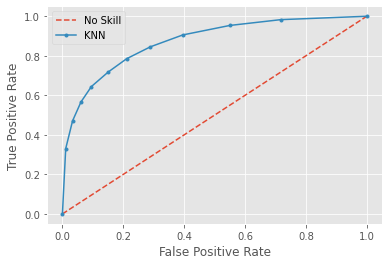

In [12]:
ns_probs = [0 for _ in range(len(y_test))]
# predict probabilities
lr_probs = knn.predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('KNN: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='KNN')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
plt.savefig("roc_curve.png",dpi=300)

# Logistic Regression

In [215]:
X = df.drop(['account_type','location','lang'],axis=1)
y = df.account_type

le = LabelEncoder()
le.fit(y)
y = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [216]:
logmodel = LogisticRegression()
logmodel.fit(X_train,y_train)
predictions = logmodel.predict(X_test)

In [217]:
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test,predictions))

[[2215  252]
 [1127 1393]]
              precision    recall  f1-score   support

           0       0.66      0.90      0.76      2467
           1       0.85      0.55      0.67      2520

    accuracy                           0.72      4987
   macro avg       0.75      0.73      0.72      4987
weighted avg       0.76      0.72      0.72      4987



No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.724


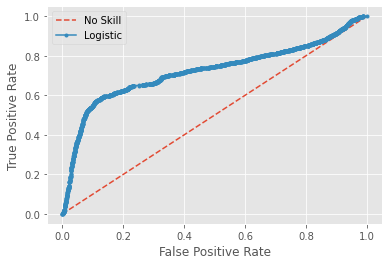

In [218]:
ns_probs = [0 for _ in range(len(y_test))]
# predict probabilities
lr_probs = logmodel.predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
plt.savefig("roc_curve.png",dpi=300)

# Naive Bayes

In [13]:
X = df.drop(['account_type','location','lang'],axis=1)
y = df.account_type

le = LabelEncoder()
le.fit(y)
y = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [14]:
model = BernoulliNB().fit(X_train, y_train)

In [15]:
predicted = model.predict(X_test)
print(confusion_matrix(y_test, predicted))
print(classification_report(y_test,predicted))

[[1719  702]
 [ 602 1964]]
              precision    recall  f1-score   support

           0       0.74      0.71      0.73      2421
           1       0.74      0.77      0.75      2566

    accuracy                           0.74      4987
   macro avg       0.74      0.74      0.74      4987
weighted avg       0.74      0.74      0.74      4987



No Skill: ROC AUC=0.500
BNB: ROC AUC=0.807


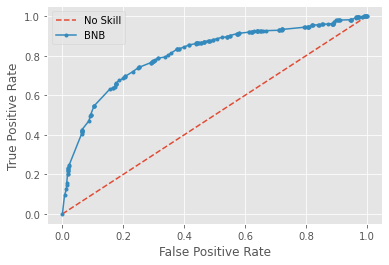

In [16]:
ns_probs = [0 for _ in range(len(y_test))]
# predict probabilities
lr_probs = model.predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('BNB: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='BNB')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
plt.savefig("roc_curve.png",dpi=300)

# Decision Tree

In [17]:
X = df.drop(['account_type','location','lang'],axis=1)
y = df.account_type

le = LabelEncoder()
le.fit(y)
y = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [18]:
classifier = DecisionTreeClassifier()
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

In [19]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[2018  479]
 [ 515 1975]]
              precision    recall  f1-score   support

           0       0.80      0.81      0.80      2497
           1       0.80      0.79      0.80      2490

    accuracy                           0.80      4987
   macro avg       0.80      0.80      0.80      4987
weighted avg       0.80      0.80      0.80      4987



No Skill: ROC AUC=0.500
Decision Trees: ROC AUC=0.801


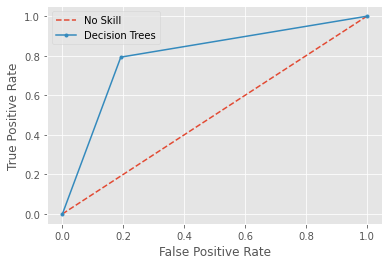

In [20]:
ns_probs = [0 for _ in range(len(y_test))]
# predict probabilities
lr_probs = classifier.predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Decision Trees: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Decision Trees')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
plt.savefig("roc_curve.png",dpi=300)

# Flask Visualization

In [228]:
# Initializing the Flask app
app = flask.Flask(__name__)
@app.route("/")
def viz_page():
    with open("awesome.html", 'r') as viz_file:
        return viz_file.read()

In [229]:
# Get the info from the sliders and obtain the prediction score
@app.route("/score", methods=["POST"])
def score():
    data = flask.request.json
    x = np.matrix(data["example"])
    score = logmodel.predict_proba(x)
    results = {"score": score[0, 1]}
    return flask.jsonify(results)

In [230]:
#Running the App
if __name__ == '__main__':
    app.run()

0 06:51:27] "POST /score HTTP/1.1" 200 -
127.0.0.1 - - [28/Oct/2020 06:51:27] "POST /score HTTP/1.1" 200 -
127.0.0.1 - - [28/Oct/2020 06:51:27] "POST /score HTTP/1.1" 200 -
127.0.0.1 - - [28/Oct/2020 06:51:27] "POST /score HTTP/1.1" 200 -
127.0.0.1 - - [28/Oct/2020 06:51:27] "POST /score HTTP/1.1" 200 -
127.0.0.1 - - [28/Oct/2020 06:51:28] "POST /score HTTP/1.1" 200 -
127.0.0.1 - - [28/Oct/2020 06:51:28] "POST /score HTTP/1.1" 200 -
127.0.0.1 - - [28/Oct/2020 06:51:28] "POST /score HTTP/1.1" 200 -
127.0.0.1 - - [28/Oct/2020 06:51:28] "POST /score HTTP/1.1" 200 -
127.0.0.1 - - [28/Oct/2020 06:51:28] "POST /score HTTP/1.1" 200 -
127.0.0.1 - - [28/Oct/2020 06:51:28] "POST /score HTTP/1.1" 200 -
127.0.0.1 - - [28/Oct/2020 06:51:28] "POST /score HTTP/1.1" 200 -
127.0.0.1 - - [28/Oct/2020 06:51:28] "POST /score HTTP/1.1" 200 -
127.0.0.1 - - [28/Oct/2020 06:51:28] "POST /score HTTP/1.1" 200 -
127.0.0.1 - - [28/Oct/2020 06:51:28] "POST /score HTTP/1.1" 200 -
127.0.0.1 - - [28/Oct/2020 06:51:28